In [1]:
library(tidyverse)
library(cansim)
library(readr)
library(vroom)
library(lubridate)
library(tseries)
library(strucchange)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'vroom'


The following objects are masked from 'package:readr':

    as.col_spec, col_character, col_date, col_datetime, col_double,
    col_factor, col_guess, col_integer, col_logical, col_number,
    col_skip, col_time, cols, cols_condense, cols_only, date_names,
    date_names_lang, date_names_langs, default_locale, fwf_cols,
    fwf_empty, fwf_positions, fwf_widths, locale, output_column,
    problems, spec


Registered S3 method overwritten by 'q

In [6]:
cpi_vec <- get_cansim_vector_for_latest_periods("v41690914", periods = 300)

cpi_vec_adj <- cpi_vec|>
select("Date", "VALUE")|>
 mutate(
    # Get the CPI value from 12 months ago
    cpi_previous_year = lag(VALUE, 12),
    # Calculate the percentage change
    cpi_change = ((VALUE  / cpi_previous_year) - 1) * 100
  )


Reading CANSIM NDM vectors from temporary cache



# A tibble: 99 × 4
   quarter VALUE cpi_previous_quarter delta_cpi
     <dbl> <dbl>                <dbl>     <dbl>
 1   2000.  96.7                 95.7    1.07  
 2   2001.  96.9                 96.7    0.241 
 3   2001.  98.2                 96.9    1.30  
 4   2001.  98.2                 98.2    0.0339
 5   2001.  97.7                 98.2   -0.510 
 6   2002.  98.4                 97.7    0.714 
 7   2002.  99.5                 98.4    1.08  
 8   2002. 101.                  99.5    1.10  
 9   2002. 101.                 101.     0.858 
10   2003. 103.                 101.     1.27  
# ℹ 89 more rows


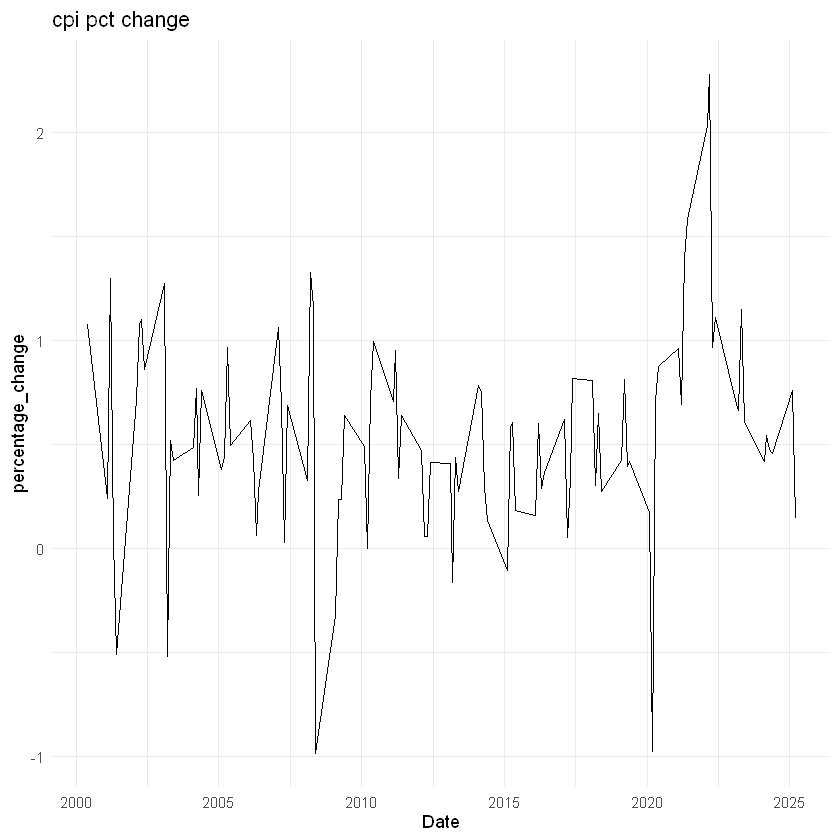

In [11]:
cpi_quarterly_stationary <- cpi_vec |>
  select(Date, VALUE) |>
  mutate(quarter = quarter(Date, with_year = TRUE)) |>
  group_by(quarter) |>
  summarise(VALUE = mean(VALUE, na.rm = TRUE)) |>
  ungroup() |>
  mutate(
    cpi_previous_quarter = lag(VALUE, 1),
    delta_cpi = (log(VALUE) - log(cpi_previous_quarter)) * 100
  )|>
drop_na()

print(cpi_quarterly_stationary)

ggplot(cpi_quarterly_stationary , aes(x = quarter, y = delta_cpi)) +
  geom_line() +
  labs(
    title = "cpi pct change",
    x = "Date",
    y = "percentage_change",
  ) +
  theme_minimal()



In [9]:
ts_data <- na.omit(cpi_quarterly_stationary$delta_cpi)


	 Optimal (m+1)-segment partition: 

Call:
breakpoints.formula(formula = y ~ x)

Breakpoints at observation number:
                      
m = 1               79
m = 2      31       79
m = 3      32 47    79
m = 4   14 32 47    79
m = 5   14 32 47 61 79

Corresponding to breakdates:
                                                                               
m = 1                                                                          
m = 2                     0.316326530612245                                    
m = 3                     0.326530612244898 0.479591836734694                  
m = 4   0.142857142857143 0.326530612244898 0.479591836734694                  
m = 5   0.142857142857143 0.326530612244898 0.479591836734694 0.622448979591837
                         
m = 1   0.806122448979592
m = 2   0.806122448979592
m = 3   0.806122448979592
m = 4   0.806122448979592
m = 5   0.806122448979592

Fit:
                                             
m   0      1      2      3 

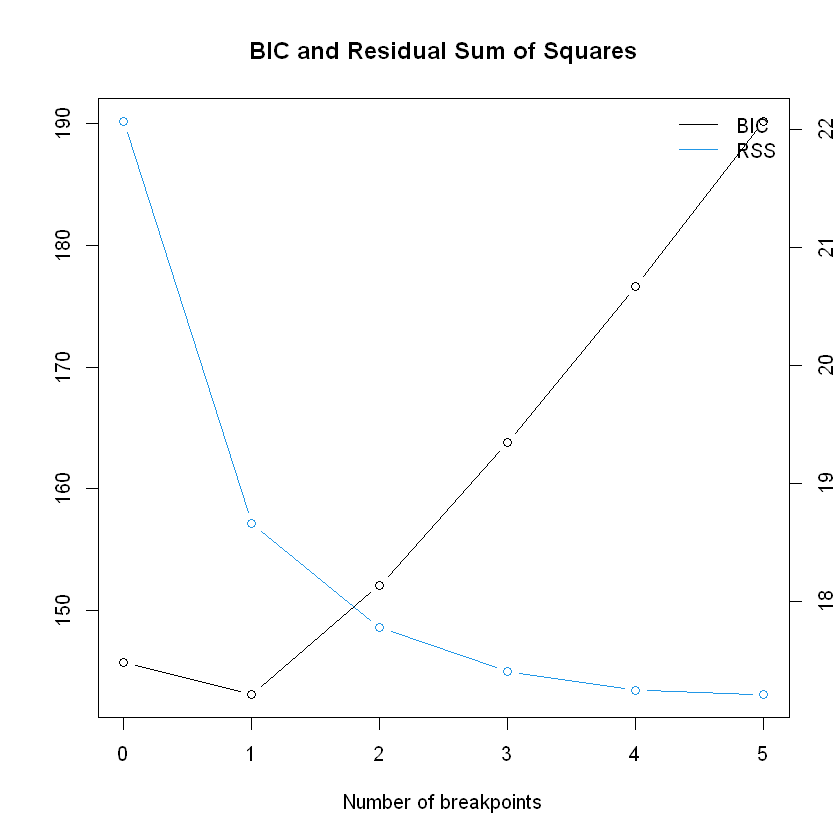

In [15]:
y <- ts_data[-1]

# 2. Create the independent variable 'x' (all values except the last)
# This is now the one-period lag of y
x <- ts_data[-length(ts_data)]

# Now 'y' and 'x' are perfectly aligned, and we can test for a break
# in the regression of y on x.
bp_test <- breakpoints(y ~ x)

# The rest is the same
summary(bp_test)
plot(bp_test)

In [16]:
break_observation <- cpi_quarterly_stationary[79, ]

print(break_observation)

# A tibble: 1 × 4
  quarter VALUE cpi_previous_quarter delta_cpi
    <dbl> <dbl>                <dbl>     <dbl>
1   2020.  137.                 137.     0.170


In [17]:
pre_break_data <- cpi_quarterly_stationary[1:79, ]
post_break_data <- cpi_quarterly_stationary[80:nrow(cpi_quarterly_stationary), ]

In [18]:
library(tseries)

# Test the pre-break period
adf.test(na.omit(pre_break_data$delta_cpi))

# Test the post-break period
adf.test(na.omit(post_break_data$delta_cpi))

Warning message in adf.test(na.omit(pre_break_data$delta_cpi)):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  na.omit(pre_break_data$delta_cpi)
Dickey-Fuller = -4.4332, Lag order = 4, p-value = 0.01
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  na.omit(post_break_data$delta_cpi)
Dickey-Fuller = -2.071, Lag order = 2, p-value = 0.5454
alternative hypothesis: stationary


In [13]:

library(vars)

Loading required package: MASS


Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select


Loading required package: urca

Loading required package: lmtest



In [33]:
print(cpi_quarterly_stationary)

# A tibble: 99 × 4
   quarter VALUE cpi_previous_quarter delta_cpi
     <dbl> <dbl>                <dbl>     <dbl>
 1   2000.  96.7                 95.7    1.07  
 2   2001.  96.9                 96.7    0.241 
 3   2001.  98.2                 96.9    1.30  
 4   2001.  98.2                 98.2    0.0339
 5   2001.  97.7                 98.2   -0.510 
 6   2002.  98.4                 97.7    0.714 
 7   2002.  99.5                 98.4    1.08  
 8   2002. 101.                  99.5    1.10  
 9   2002. 101.                 101.     0.858 
10   2003. 103.                 101.     1.27  
# ℹ 89 more rows


In [34]:
library(dplyr)

In [36]:
cpi_quarterly_stationary_var <- cpi_quarterly_stationary |>
  dplyr::select(delta_cpi)

In [39]:
lag_selection <- VARselect(cpi_quarterly_stationary_var, lag.max = 10, type = "const")

# Print the results
print(lag_selection$selection)

AIC(n)  HQ(n)  SC(n) FPE(n) 
     9      1      1      9 


In [46]:
ar_model <- ar(cpi_quarterly_stationary_var, p = 9, type = "const")

# Print a summary of the model's results
summary(ar_model)

             Length Class  Mode     
order         1     -none- numeric  
ar            9     -none- numeric  
var.pred      1     -none- numeric  
x.mean        1     -none- numeric  
aic          20     -none- numeric  
n.used        1     -none- numeric  
n.obs         1     -none- numeric  
order.max     1     -none- numeric  
partialacf   19     -none- numeric  
resid        99     -none- numeric  
method        1     -none- character
series        1     -none- character
frequency     1     -none- numeric  
call          4     -none- call     
asy.var.coef 81     -none- numeric  

In [43]:
install.packages("FinTS")
library(FinTS)

package 'FinTS' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Irene\AppData\Local\Temp\Rtmpo5jsJb\downloaded_packages


In [47]:
model_residuals <- residuals(ar_model)

In [51]:

model_residuals <- na.omit(ar_model$resid)

# Check the length
print(length(model_residuals))

[1] 90


In [54]:
library(FinTS)

# Run the test with a smaller number of lags
# For example, if you have 20 residuals, a lag of 4 is reasonable.
arch_test_result <- ArchTest(model_residuals, lags = 12)

# Print the results
print(arch_test_result)


	ARCH LM-test; Null hypothesis: no ARCH effects

data:  model_residuals
Chi-squared = 7.7627, df = 12, p-value = 0.8034

